# PinaColADA Phase 2 Notebook 

The Youniverse dataset consists of 3 main sub-datasets : the channel dataset, the video dataset and the timeseries data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import axes
import matplotlib.dates as mdates
from matplotlib import dates
from matplotlib import ticker
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
from ThymeBoost import ThymeBoost as tb
import random
from datetime import datetime, timedelta
import math
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
import pickle
from sklearn.metrics import silhouette_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error

### Importing data 

In [108]:
DIR = "./data/"
PATH_CHANNELS_DST = DIR + "df_channels_en.tsv"
PATH_TIME_SERIES_DST = DIR + "df_timeseries_en.tsv"
PATH_COMMENTS_AUTHOR_DST = DIR + "num_comments_authors.tsv"
PATH_COMMENTS_DST = DIR + "num_comments.tsv"
PATH_METADATA_DST = DIR + "yt_metadata_en.jsonl"
PATH_METADATA_HELPER = DIR + "yt_metadata_helper.feather"

In [109]:
channels = pd.read_csv(PATH_CHANNELS_DST, sep = '\t')
channels['join_date']= pd.to_datetime(channels['join_date'])
channels.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [4]:
timeseries = pd.read_csv(PATH_TIME_SERIES_DST, sep = '\t')
timeseries['datetime'] = pd.to_datetime(timeseries['datetime'])
timeseries = timeseries.round(decimals=3)
timeseries['category'] = timeseries['category'].fillna('Undefined')
timeseries.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,202494.556,0.000,650.222,0.000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,394085.667,191591.111,1046.000,395.778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,835393.750,441308.083,1501.500,455.500,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1104577.000,269183.250,1750.000,248.500,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1284405.600,179828.600,2008.300,258.300,6,0,0


In [5]:
timeseries.to_pickle("./timeseries.pkl")

In [2]:
timeseries = pd.read_pickle("./timeseries.pkl")

### Channels data exploration

In [5]:
channels.describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights
count,1.364700e+05,136470.000000,1.364700e+05,136470.000000
mean,2.466022e+05,699.784231,3.570087e+05,7.349363
std,1.150096e+06,4524.980928,2.711139e+05,5.277328
min,1.000000e+04,10.000000,3.000000e+00,2.086500
25%,1.888575e+04,70.000000,1.161305e+05,4.231500
50%,4.240000e+04,175.000000,3.015670e+05,6.444000
75%,1.370000e+05,443.000000,5.704942e+05,9.243500
max,1.121395e+08,461923.000000,1.030844e+06,53.150500


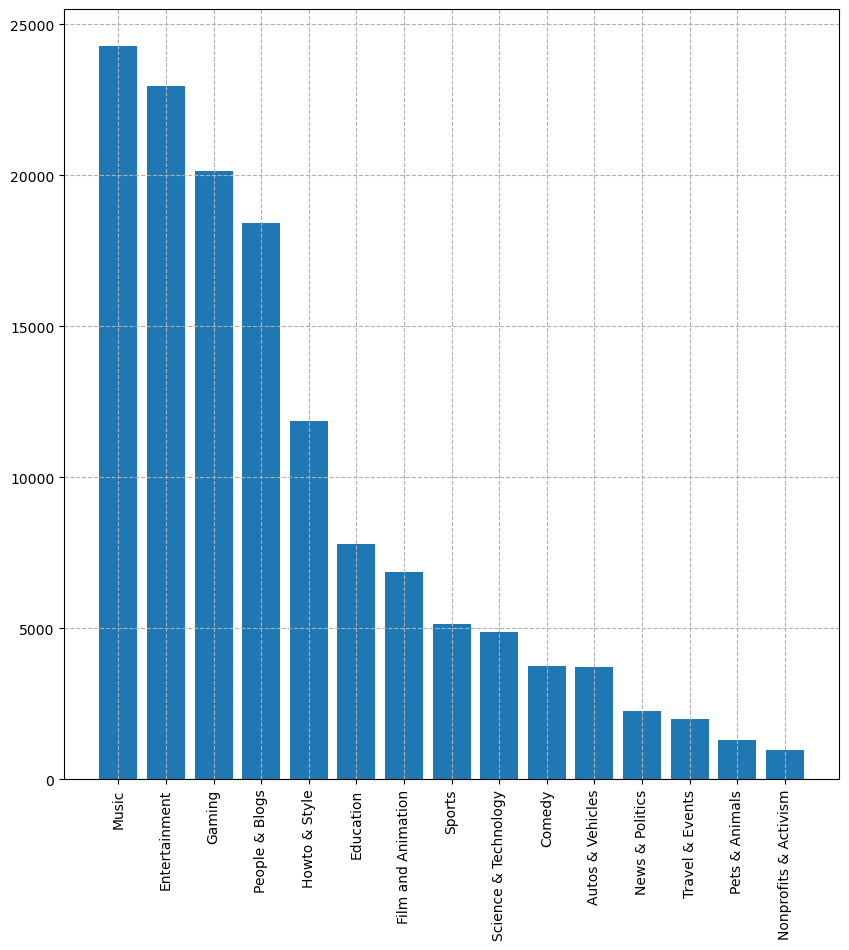

In [6]:
# Group the channels by categories
categories = channels.groupby(['category_cc']).size().to_frame()
categories.rename(columns={0:'count'}, inplace=True)

# Sort and plot the resulting data
categories.sort_values(by='count', ascending=False, inplace=True)
plt.figure(figsize=(10,10))
plt.grid(linestyle='--')
plt.bar(categories.index, categories['count'])
plt.xticks(rotation = 90)
plt.show()

We can see that there is a minority of categories that concentrate a large part of the channels: this can be explained by the fact that these are categories with much broader subjects than others (such as for example Entertainment compared to Pets & Animals) but also by the fact that some can be used by actors fondamentally different than typical Youtube content creators (like Music with artist channels).


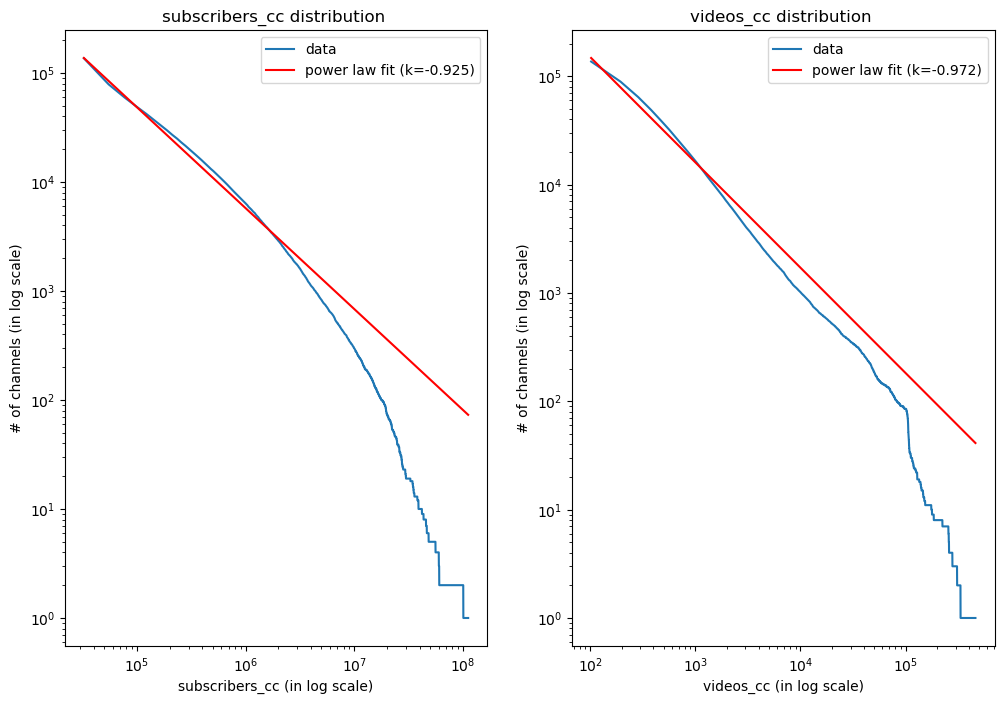

In [7]:
# Power law definition : required for fitting the data
def power_law(x, a, k):
    return a * (x ** k)

# For each category to plot :
power_law_cat = ['subscribers_cc', 'videos_cc']
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

for idx, cat in enumerate(power_law_cat):
    
    # Group the data into bins
    array_hist = ax[idx].hist(channels[cat], bins=5000,log=True,cumulative=-1,histtype='step')
    ax[idx].clear()
    
    # Fit the data to find a suitable power law
    popt, pcov = curve_fit(power_law,array_hist[1][1:],  array_hist[0])
    
    # Plot both the data and the fitted function
    ax[idx].loglog(array_hist[1][1:],array_hist[0], label='data')
    ax[idx].loglog(array_hist[1][1:], power_law(array_hist[1][1:], *popt), 'r-', label='power law fit (k=%.3f)' % tuple(popt)[1])
    ax[idx].set_title(f'{cat} distribution ')
    ax[idx].set_ylabel('# of channels (in log scale)')
    ax[idx].set_xlabel(f'{cat} (in log scale)')
    ax[idx].legend()

plt.show()                                                                  

The subscribers count follows a power law : the vast majority of Youtube channels have a low number of subscribers while only a few channel concentrate the major part of subscriptions.
We can also make this statement about the number of published videos per channels

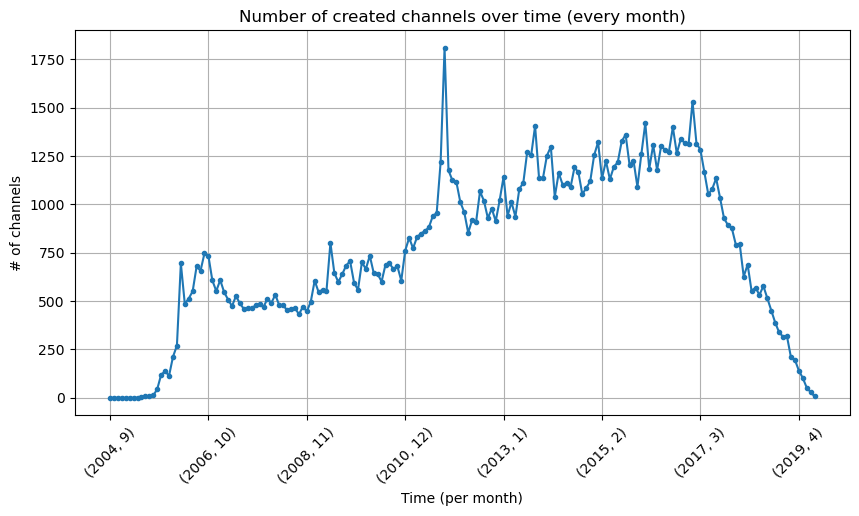

In [8]:
# Count the value of join_date 
creation_dt_df = channels['join_date'].value_counts().to_frame()

# Add missing values (if there was no channel created during a certain month we have to add 0-entry to our dataframe)
idx = pd.date_range(creation_dt_df.index.min(), creation_dt_df.index.max())
creation_dt_df.index = pd.DatetimeIndex(creation_dt_df.index)
creation_dt_df = creation_dt_df.reindex(idx, fill_value=0)

# Group the data by year and month to get an approrpiate scale
creation_dt_df = creation_dt_df.groupby([(creation_dt_df.index.year), (creation_dt_df.index.month)]).sum()

# Plot the final dataset 
creation_dt_df.plot(kind='line',figsize=(10,5), grid='--', legend=False, rot=45, marker=".")
plt.title('Number of created channels over time (every month)')
plt.ylabel('# of channels')
plt.xlabel('Time (per month)')
plt.show()

We can see that there is a considerable attraction for Youtube from its creation in 2005 and in the 2010s followed by a significant drop from 2017 where less and less channels are created.

### Timeseries data exploration

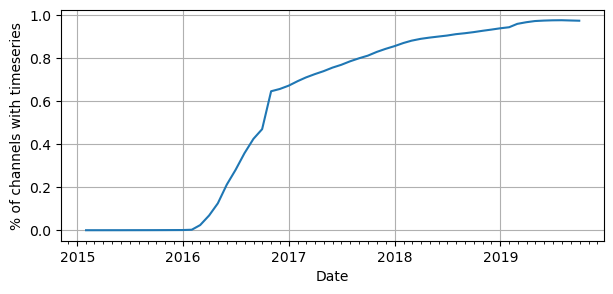

In [9]:
# Group the channel month 
datetimes = timeseries.groupby(pd.Grouper(key="datetime", freq="M")).channel.nunique()
channels_tot = len(timeseries.channel.unique())

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(1, figsize=(7,3), sharey=True, sharex=True,
                       gridspec_kw={"wspace": 0.05})
# sns.lineplot(data=(datetimes / channels_tot), ax=ax)
ax.plot(datetimes / channels_tot)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.set_xlabel("Date")
ax.set_ylabel("% of channels with timeseries")
ax.grid()

From the graph above, we can see that there is relatively big expansion of the number of channels from 2016 to 2017 and grows slower after. From that we decide to pick only timeseries starting timestamp in March 2017. Also we decide to take channels that have at least 140 timestamps (which correspond to ~3 years)

In [4]:
timeseries_filtered = timeseries[timeseries.datetime >= pd.to_datetime("2017-3-1")]
print("We know have {} datapoints".format(len(timeseries_filtered)))

We know have 15899418 datapoints


### Timestamps uniformization

In [5]:
channel_timeseries = pd.pivot_table(timeseries_filtered, values='delta_views', 
                                index=['datetime'], 
                                columns=['channel'])
print("Without uniformization, we have {} rows.".format(len(channel_timeseries)))
channel_timeseries.head()

Without uniformization, we have 270 rows.


channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3c8RqSfAqYBdDjIG3UNA,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--7oyGW0N7fMf164-ZXljQ,UC--94OGFAzYDOJb0eXgMjew,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,...,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzztaOtjmaZoiLvWLagq7bg,UCzzyt9Z70MBX9RQAFVSNlpQ,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-05 23:00:00,5084.151,29511.854,NaN,79230.630,81655.203,80741.172,NaN,NaN,185740.719,3194.245,...,1299.214,10319.792,NaN,16790.245,7451.599,NaN,NaN,21433.500,0.0,66594.318
2017-03-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,337.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-12 23:00:00,4121.281,27776.422,NaN,75579.474,111415.917,56396.365,NaN,NaN,176101.714,1703.115,...,3388.875,8655.021,NaN,17796.646,7980.000,NaN,NaN,37286.031,0.0,66848.464
2017-03-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,370.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-19 23:00:00,3331.469,29902.391,NaN,81068.396,70171.418,46221.240,NaN,NaN,185874.396,1472.786,...,2478.203,10301.375,NaN,18620.229,12789.391,NaN,NaN,53305.041,0.0,63590.495


When setting up our data structure, we noticed that there was some small issues in the timeseries datapoints timsestamp : as the data was not crawled at exactly the same time for all channels, there are not the same all across. If we look at the table just above, you can see that there are timestamps that should have been pooled at around the same time that have a 2-hour difference, resulting in additional rows for parts of the dataset. We have timestamps for one day at 23h00 and for the day after at 1h00 or 00h00.

Since the hour of the time isn't relevant in our study, we decided to substract 2-hour from the timestamp : for the timestamp indicating 23h00, this won't change anything but for the timestamp indicating 00h00 or 01h00, this will change the current timestamp day to the previous day, which uniforms timestamps for all channels. 

In [6]:
# Project the timestamp to the correct day
timeseries_filtered.datetime = timeseries_filtered.datetime - timedelta(hours = 2)
# Drop the time to only keep the day
timeseries_filtered.datetime = pd.to_datetime(timeseries_filtered.datetime).dt.date
channel_timeseries = pd.pivot_table(timeseries_filtered, values='delta_views', 
                                index=['datetime'], 
                                columns=['channel'])
print("With uniformization, we have {} rows.".format(len(channel_timeseries)))
channel_timeseries.head()

With uniformization, we have 135 rows.


channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3c8RqSfAqYBdDjIG3UNA,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--7oyGW0N7fMf164-ZXljQ,UC--94OGFAzYDOJb0eXgMjew,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,...,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzztaOtjmaZoiLvWLagq7bg,UCzzyt9Z70MBX9RQAFVSNlpQ,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-05,5084.151,29511.854,NaN,79230.630,81655.203,80741.172,NaN,NaN,185740.719,3194.245,...,1299.214,10319.792,337.750,16790.245,7451.599,NaN,NaN,21433.500,0.0,66594.318
2017-03-12,4121.281,27776.422,NaN,75579.474,111415.917,56396.365,NaN,NaN,176101.714,1703.115,...,3388.875,8655.021,370.125,17796.646,7980.000,NaN,NaN,37286.031,0.0,66848.464
2017-03-19,3331.469,29902.391,NaN,81068.396,70171.418,46221.240,NaN,NaN,185874.396,1472.786,...,2478.203,10301.375,195.375,18620.229,12789.391,NaN,NaN,53305.041,0.0,63590.495
2017-03-26,3510.386,33918.421,NaN,96758.761,52380.817,47386.811,NaN,NaN,202878.457,1365.533,...,1860.859,10000.878,187.035,16477.597,8400.880,NaN,NaN,43613.152,0.0,53842.747
2017-04-02,3238.031,36958.507,NaN,72781.822,45465.000,40488.814,NaN,NaN,179269.194,1098.597,...,3452.360,10132.440,205.137,15349.730,9352.778,NaN,NaN,38612.000,0.0,37897.430


There is still some NaN values in the which is normal because not every channel have all timestamps.

### Timestamp distribution

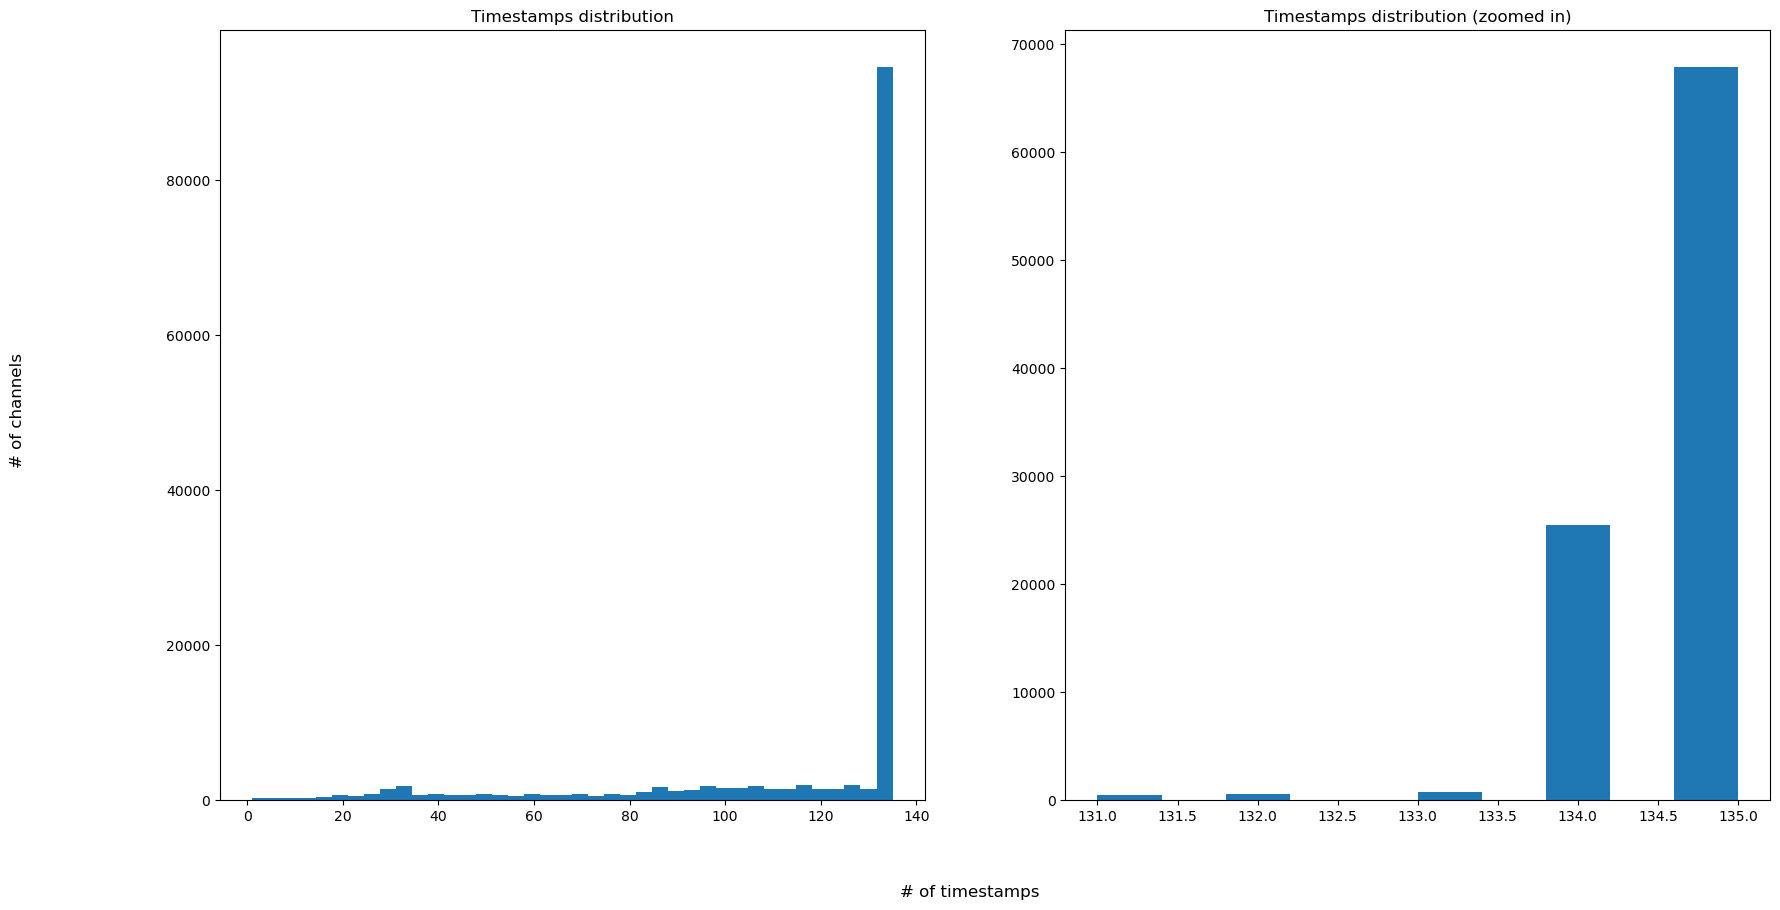

In [7]:
timeseries_sizes = channel_timeseries.count().to_frame()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].hist(timeseries_sizes[0], bins=40)
axes[0].set_title('Timestamps distribution')

axes[1].hist(timeseries_sizes[timeseries_sizes[0]>130], bins=10)
axes[1].set_title('Timestamps distribution (zoomed in)')
fig.supxlabel('# of timestamps')
fig.supylabel('# of channels')
plt.show()

Here you can see that we have the correct number of timestamp that we found in the graph above. Because of this given distribution, we decided to only keep timseries with a small amount of missing timestamps.

In [8]:
channel_timeseries = channel_timeseries.dropna(thresh=len(channel_timeseries) - 1, axis=1)
channel_timeseries.head()

channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,UC--LAVm36WiCmqQbekV17qQ,UC--MxpGXJ3LVD8KvlNzRlcA,UC--SaadDxRXz729rtbQqyBA,...,UCzzfu83LhPMMuhtDVA75rfw,UCzzgEOi0xR9SuflkXmTQv6g,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-05,5084.151,29511.854,79230.630,81655.203,80741.172,185740.719,3194.245,345128.635,154075.526,75592.406,...,98601.505,69613.802,1299.214,10319.792,337.750,16790.245,7451.599,21433.500,0.0,66594.318
2017-03-12,4121.281,27776.422,75579.474,111415.917,56396.365,176101.714,1703.115,262139.146,154464.932,78428.974,...,82980.260,78330.370,3388.875,8655.021,370.125,17796.646,7980.000,37286.031,0.0,66848.464
2017-03-19,3331.469,29902.391,81068.396,70171.418,46221.240,185874.396,1472.786,287710.500,162342.188,85739.453,...,63900.214,85821.021,2478.203,10301.375,195.375,18620.229,12789.391,53305.041,0.0,63590.495
2017-03-26,3510.386,33918.421,96758.761,52380.817,47386.811,202878.457,1365.533,219151.809,182142.246,93298.148,...,58096.004,78115.357,1860.859,10000.878,187.035,16477.597,8400.880,43613.152,0.0,53842.747
2017-04-02,3238.031,36958.507,72781.822,45465.000,40488.814,179269.194,1098.597,205884.004,133568.796,73309.571,...,62431.965,68790.221,3452.360,10132.440,205.137,15349.730,9352.778,38612.000,0.0,37897.430


In [9]:
nan_rows = channel_timeseries[channel_timeseries.isna().any(axis=1)]
print(nan_rows.index.values)

[datetime.date(2017, 3, 5) datetime.date(2019, 9, 29)]


In [10]:
long_timeseries = timeseries_filtered[timeseries_filtered['channel'].isin(channel_timeseries.columns)]
long_timeseries = long_timeseries.drop(long_timeseries[long_timeseries['datetime'].isin(nan_rows.index.values)].index)
print(len(long_timeseries))
long_timeseries.head()

12425259


,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
168,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-03-12,1.768565e+07,0.000,8162.125,31.375,835,0,0
169,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-03-19,1.770991e+07,24259.750,8193.500,31.375,835,0,0
170,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-03-26,1.778612e+07,76201.330,8229.094,35.594,835,0,0
171,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-04-02,1.786131e+07,75191.410,8267.677,38.583,835,0,0
172,UCXhkGgooXHDNwgJXmoTSN7g,Music,2017-04-09,1.793984e+07,78537.104,8299.250,31.573,835,0,0


In [11]:
long_timeseries.to_pickle("./cleantimeseries.pkl")

In [2]:
long_timeseries = pd.read_pickle("./cleantimeseries.pkl")

### Distribution of the mean deltaviews

The plot consist of the number of channels that have the same delta views mean accross the time serie.

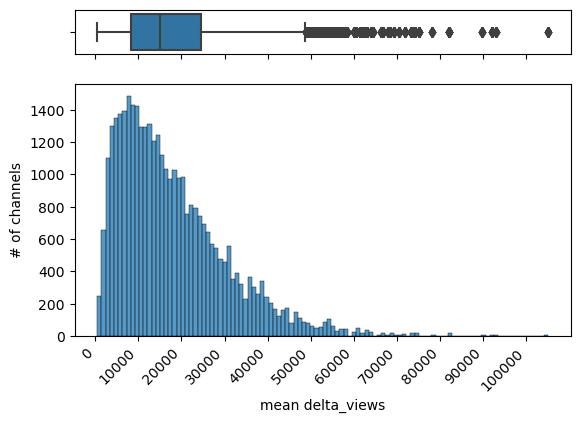

In [4]:
means = long_timeseries.groupby('channel')['delta_views'].mean().round(-1).astype(int)
vc = means.value_counts()[means.value_counts() > 7]
means = means[np.isin(means.values, (vc.index))]

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=means, ax=ax_box)
sns.histplot(x=means, ax=ax_hist)
ax_hist.set_xticks(range(0, 110000, 10000))
ax_box.set_xticks(range(0, 110000, 10000))
ax_hist.set_xlabel("mean delta_views")
ax_hist.set_ylabel("# of channels")
f.autofmt_xdate(rotation=45)

Most of the channels have delta_views's mean between 8k - 28k

### Linear Regression of delta views

Loop over all channels to compute the slope and intercept value used for the linear regression. All data are min-max normalize.

In [43]:
slopes = []
for name, channel_df in tqdm(long_timeseries.groupby('channel')):
    dv = channel_df['delta_views']
    normalized_df=(dv-dv.min())/(dv.max() - dv.min())
    res = stats.linregress(range(len(channel_df)), normalized_df.values)
    slopes.append((name, res.slope, res.intercept))

100%|██████████| 67936/67936 [00:22<00:00, 3086.59it/s]


Sort the list according to the slopes to see the downfall / rise of channels

In [44]:
slopes_sort = sorted(slopes, key=lambda x: x[1])

Text(0.5, 0.98, 'The most falling / stagnating / rising channels')

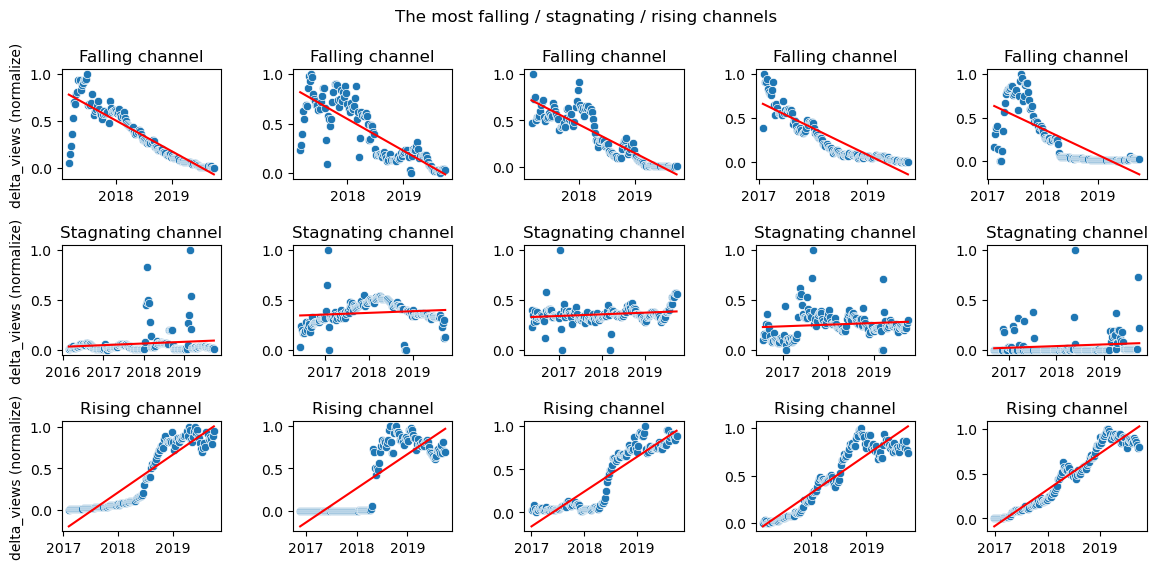

In [45]:
f, axs = plt.subplots(3, 5, figsize=(14, 6), gridspec_kw={"wspace": 0.45, "hspace": 0.6, 
                                      "height_ratios": [1, 1, 1]})

for i, ax in enumerate(axs[0]):
    idx = i
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Falling channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

for i, ax in enumerate(axs[1]):
    idx = i + int(len(slopes_sort) / 2)
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")    
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Stagnating channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

for i, ax in enumerate(axs[2]):
    idx = -(i + 1)
    df = long_timeseries[long_timeseries['channel'] == slopes_sort[idx][0]]
    normalized_df=(df['delta_views']-df['delta_views'].min())/(df['delta_views'].max() - df['delta_views'].min())
    sns.scatterplot(x=df['datetime'], y=normalized_df, ax=ax)
    ax.plot(df['datetime'], slopes_sort[idx][2] + range(len(df)) * slopes_sort[idx][1], color="red")
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.set_title("Rising channel")
    if i == 0:
        ax.set_ylabel("delta_views (normalize)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

f.suptitle("The most falling / stagnating / rising channels")

## Dealing with outliers

### Delta_views

As we can see there clearly, there is some channels that, according to our regression, are stagning. But is it truly the case? Look for example the plot in the middle. (2nd row, 1st column). There are some outliers that might influence the regression and hence show that the channel is stagning which is not necessarly the case.

In this way, we wanted to see if outliers indeed influence the slopes or not. In other words, does the slopes with and without outlier changes? Thoses potential changes happend often, in terms of number of channels?. We are doing this to know if outliers influence the rising or the falling and also to answer the question: Does a popular video makes you channel bigger or not?

In [89]:
# Compute the slopes with and without outliers
boosted_model = tb.ThymeBoost()
slope_with_outliers = []
slope_without_outliers = []
for name, channel_df in tqdm(long_timeseries.groupby('channel')):

    df_norm = (channel_df['delta_views']-channel_df['delta_views'].min())/(channel_df['delta_views'].max() - channel_df['delta_views'].min())
    
    output = boosted_model.detect_outliers(df_norm,
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')
    
    slope = output.yhat.iloc[1] - output.yhat.iloc[0]
    slope_with_outliers.append((name, slope, output.yhat.iloc[0]))

    df = df_norm.copy()
    df[output.outliers] = output[output.outliers].yhat

    output_without_outlier = boosted_model.detect_outliers(df,
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')

    slope = output_without_outlier.yhat.iloc[1] - output_without_outlier.yhat.iloc[0]
    slope_without_outliers.append((name, slope, output_without_outlier.yhat.iloc[0]))

dict_slope_with_outliers = {}
for el in slope_with_outliers:
    dict_slope_with_outliers[el[0]] = {"slope": el[1], "intercept": el[2]}
    
dict_slope_without_outliers = {}
for el in slope_without_outliers:
    dict_slope_without_outliers[el[0]] = {"slope": el[1], "intercept": el[2]}

diff_slopes = {}
for name in dict_slope_with_outliers:
    diff_slopes[name] = abs(dict_slope_with_outliers[name]["slope"] - dict_slope_without_outliers[name]["slope"])

100%|██████████| 93423/93423 [08:22<00:00, 186.01it/s]


In [93]:
def sample_from_dict(d, sample=100):
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    return dict(zip(keys, values))

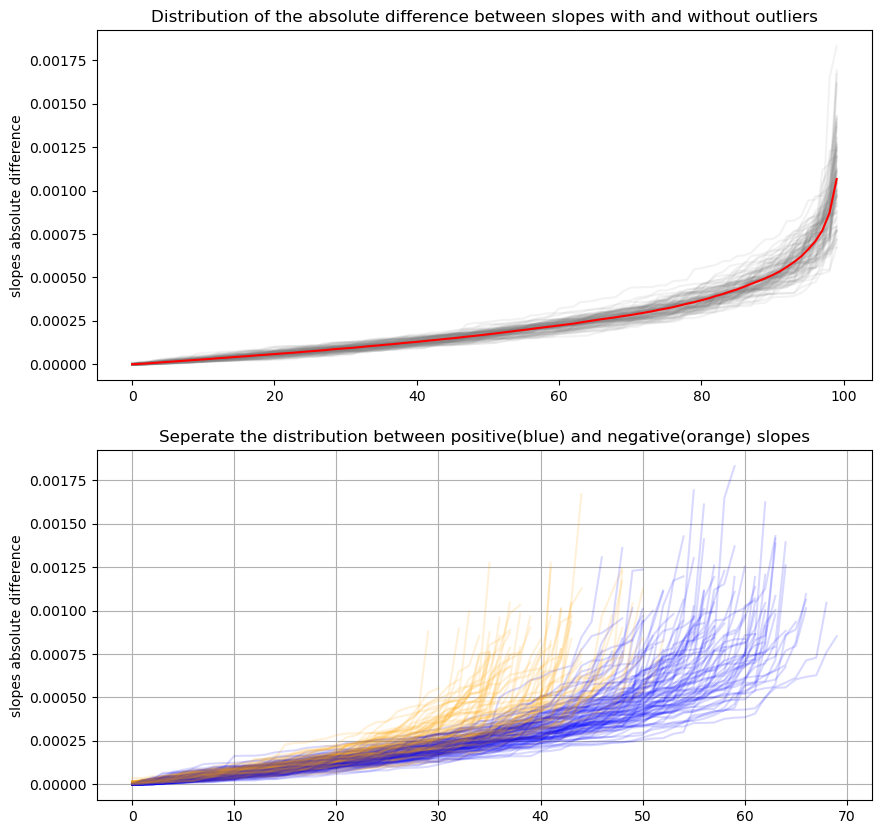

In [166]:
N = 100
mean = 0
mean_pos = np.zeros(N)
mean_neg = np.zeros(N)
fig, ax = plt.subplots(2, figsize=(10, 10))
for i in range(N):
    sample_diff_slopes = sample_from_dict(diff_slopes)
    sample_diff_slopes_df = pd.DataFrame.from_dict(sample_diff_slopes, orient='index', columns=['slopes'])
    mean += sample_diff_slopes_df.slopes.sort_values().values / N
    ax[0].plot(range(len(sample_diff_slopes_df.index)), sample_diff_slopes_df.slopes.sort_values(), color="grey", alpha=0.1)

    #######################################################################################################################

    sample_dict_slope_with_outliers = {key: dict_slope_with_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}
    sample_dict_slope_without_outliers = {key: dict_slope_without_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}

    sample_diff_slopes_df = pd.DataFrame.from_dict(sample_diff_slopes, orient='index', columns=['slopes'])
    sample_slope_with_outliers_df = pd.DataFrame.from_dict(sample_dict_slope_with_outliers, orient='index', columns=['slopes'])
    sample_slope_without_outliers_df = pd.DataFrame.from_dict(sample_dict_slope_without_outliers, orient='index', columns=['slopes'])

    s = sample_slope_with_outliers_df[sample_slope_with_outliers_df.slopes >= 0]
    u = sample_diff_slopes_df[sample_diff_slopes_df.index.isin(s.index)]
    # mean_pos += np.hstack([u.slopes.sort_values().values, np.ones(N - len(u.slopes.sort_values().values)) * u.slopes.sort_values().values[-1]]) / N
    ax[1].plot(range(len(u)), u.slopes.sort_values(), color="blue", alpha=0.15)

    t = sample_slope_with_outliers_df[sample_slope_with_outliers_df.slopes < 0]
    v = sample_diff_slopes_df[sample_diff_slopes_df.index.isin(t.index)]
    # mean_neg += np.hstack([v.slopes.sort_values().values, np.ones(N - len(v.slopes.sort_values().values)) * v.slopes.sort_values().values[-1]]) / N
    ax[1].plot(range(len(v)), v.slopes.sort_values(), color="orange", alpha=0.15)

ax[0].plot(range(len(sample_diff_slopes_df.index)), mean, color="red")
ax[0].set_title("Distribution of the absolute difference between views slopes with and without outliers")
ax[0].set_ylabel("views slopes absolute difference")

ax[1].set_title("Seperate the distribution between positive(blue) and negative(orange) views slopes")
ax[1].set_ylabel("views slopes absolute difference")
ax[1].grid()

la distrbution de difference de slope entre avec et sans outlier est differente pour les negatives et positve slope. Pourquoi faire ça? Identifier un pattern qui pour donner des raisons de rise or fall. On peut voir que la distribution est la même et est plutot chaotique
On peut voir qu'il y a plus de chaine avec des slope positive que negative, ce qui impliquerai que le nombre de chaine rising dans youtube augmente. Cependant, nous voyons que la courbe (grpahe 1) de l'absolute difference est exponentiel, meaning most of the channels outliers doesn't really affect the curve of the delta_views time-series.

### Delta_subs

In [177]:
# Compute the slopes with and without outliers
boosted_model = tb.ThymeBoost()
subs_with_outliers = []
subs_without_outliers = []
for name, channel_df in tqdm(long_timeseries.groupby('channel')):

    df_norm = (channel_df['delta_subs']-channel_df['delta_subs'].min())/(channel_df['delta_subs'].max() - channel_df['delta_subs'].min())
    if (df_norm.isnull().values.any()):
        continue
    output = boosted_model.detect_outliers(df_norm,
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')
    
    slope = output.yhat.iloc[1] - output.yhat.iloc[0]
    subs_with_outliers.append((name, slope, output.yhat.iloc[0]))

    df = df_norm.copy()
    df[output.outliers] = output[output.outliers].yhat

    output_without_outlier = boosted_model.detect_outliers(df,
                                        trend_estimator='linear',
                                        seasonal_estimator='fourier',
                                        global_cost='maicc',
                                        fit_type='global')

    slope = output_without_outlier.yhat.iloc[1] - output_without_outlier.yhat.iloc[0]
    subs_without_outliers.append((name, slope, output_without_outlier.yhat.iloc[0]))

dict_subs_with_outliers = {}
for el in subs_with_outliers:
    dict_subs_with_outliers[el[0]] = {"slope": el[1], "intercept": el[2]}

dict_subs_without_outliers = {}
for el in subs_without_outliers:
    dict_subs_without_outliers[el[0]] = {"slope": el[1], "intercept": el[2]}

diff_subs = {}
for name in dict_subs_with_outliers:
    diff_subs[name] = abs(dict_subs_with_outliers[name]["slope"] - dict_subs_without_outliers[name]["slope"])

100%|██████████| 93423/93423 [08:12<00:00, 189.70it/s]


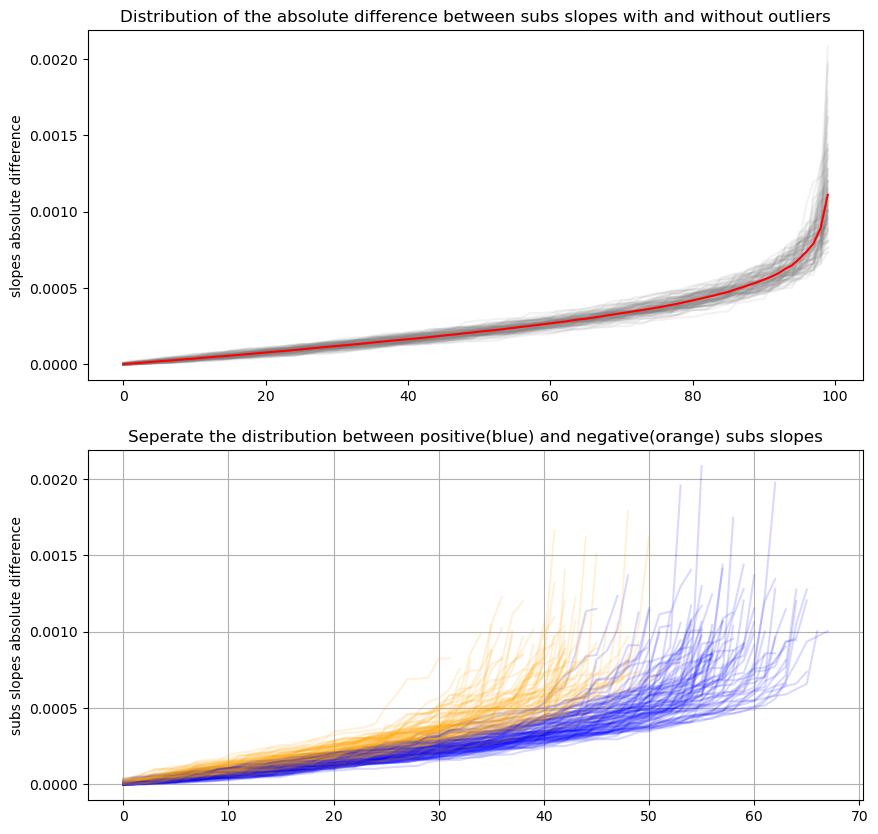

In [179]:
N = 100
mean = 0
mean_pos = np.zeros(N)
mean_neg = np.zeros(N)
fig, ax = plt.subplots(2, figsize=(10, 10))
for i in range(N):
    sample_diff_slopes = sample_from_dict(diff_subs)
    sample_diff_slopes_df = pd.DataFrame.from_dict(sample_diff_slopes, orient='index', columns=['slopes'])
    mean += sample_diff_slopes_df.slopes.sort_values().values / N
    ax[0].plot(range(len(sample_diff_slopes_df.index)), sample_diff_slopes_df.slopes.sort_values(), color="grey", alpha=0.1)

    #######################################################################################################################

    sample_dict_subs_with_outliers = {key: dict_subs_with_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}
    sample_dict_subs_without_outliers = {key: dict_subs_without_outliers[key]['slope'] for key in list(sample_diff_slopes.keys())}

    sample_diff_slopes_df = pd.DataFrame.from_dict(sample_diff_slopes, orient='index', columns=['slopes'])
    sample_slope_with_outliers_df = pd.DataFrame.from_dict(sample_dict_subs_with_outliers, orient='index', columns=['slopes'])
    sample_slope_without_outliers_df = pd.DataFrame.from_dict(sample_dict_subs_without_outliers, orient='index', columns=['slopes'])

    s = sample_slope_with_outliers_df[sample_slope_with_outliers_df.slopes >= 0]
    u = sample_diff_slopes_df[sample_diff_slopes_df.index.isin(s.index)]
    # mean_pos += np.hstack([u.slopes.sort_values().values, np.ones(N - len(u.slopes.sort_values().values)) * u.slopes.sort_values().values[-1]]) / N
    ax[1].plot(range(len(u)), u.slopes.sort_values(), color="blue", alpha=0.15)

    t = sample_slope_with_outliers_df[sample_slope_with_outliers_df.slopes < 0]
    v = sample_diff_slopes_df[sample_diff_slopes_df.index.isin(t.index)]
    # mean_neg += np.hstack([v.slopes.sort_values().values, np.ones(N - len(v.slopes.sort_values().values)) * v.slopes.sort_values().values[-1]]) / N
    ax[1].plot(range(len(v)), v.slopes.sort_values(), color="orange", alpha=0.15)

ax[0].plot(range(len(sample_diff_slopes_df.index)), mean, color="red")
ax[0].set_title("Distribution of the absolute difference between subs slopes with and without outliers")
ax[0].set_ylabel("slopes absolute difference")

ax[1].set_title("Seperate the distribution between positive(blue) and negative(orange) subs slopes")
ax[1].set_ylabel("subs slopes absolute difference")
ax[1].grid()

We have basically the same graphs which could have been predict since views and subs are corrolated. The more subs the more views you have.

# Clustering into profiles

The next idea is instead of looking at specific events that might have changed the evolution of a channel, to try to find general trends. Let's see if the channels can be clustered into different profiles depending on the evolution of an indicator. We use the delta-indicators and not the base values themselves because as they are not cumulative, the differences between them are visually easier to see.
We start with the delta-views.

In [17]:
views_timeseries = pd.pivot_table(long_timeseries, values='delta_views', index=['datetime'], columns=['channel'])
date_index = views_timeseries.index

We have oscillations in the data so we use some smoothing to get cleaner time series to get a better clustering results. We tried a rolling average but it was not enough, it only rounded the oscillations. We finally went with an exponential soothing method.

In [3]:
def exp_smoothing(series,decay):
    return series.ewm(com=decay).mean()

def rolling_smoothing(series,span):
    return series.rolling(span,min_periods=1).mean()

In [19]:
views_timeseries = exp_smoothing(views_timeseries,2)
views_timeseries.head()

channel,UC--24Q3_ZQeFmgJE-Um5QZQ,UC--2EbuIuBOGgGqPiJxi3rg,UC--3ozenTzry39-xMqAPQlw,UC--6E6EpybocdaNlPhvK_9A,UC--70ql_IxJmhmqXqrkJrWQ,UC--BMyA2X4a9PGAo3lTuopg,UC--EwQJeJ6SKlJdswehQH4g,UC--LAVm36WiCmqQbekV17qQ,UC--MxpGXJ3LVD8KvlNzRlcA,UC--SaadDxRXz729rtbQqyBA,...,UCzzfu83LhPMMuhtDVA75rfw,UCzzgEOi0xR9SuflkXmTQv6g,UCzzmGsmy8cBxmqljbVG_e7Q,UCzzoJY_ln_StRVdrRX1_ftg,UCzzqd0yx7h1PuC3KJVqeJgw,UCzzsKg4jPGBL05t2w3HfHBA,UCzzt-UNlRHbEFY3rEpFpuXw,UCzzzPMh9fZHxc7gxPRB2LHQ,UCzzzUN8yvD2LRAnY-lhzyLQ,UCzzzZ3-icktxbC3j7hkWqRw
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-12,4121.281000,27776.422000,75579.474000,111415.917000,56396.365000,176101.714000,1703.115000,262139.146000,154464.932000,78428.974000,...,82980.260000,78330.370000,3388.875000,8655.021000,370.125000,17796.646000,7980.000000,37286.031000,0.0,66848.464000
2017-03-19,3647.393800,29052.003400,78872.827200,86669.217600,50291.290000,181965.323200,1564.917600,277481.958400,159191.285600,82815.261400,...,71532.232400,82824.760600,2842.471800,9642.833400,265.275000,18290.795800,10865.634600,46897.437000,0.0,64893.682600
2017-03-26,3582.495368,31357.148579,87345.111632,70427.343632,48915.484158,191871.544474,1470.472263,249851.887632,170062.793158,87780.839263,...,65167.703158,80593.990474,2377.497316,9812.433474,228.213947,17431.912158,9698.119263,45341.723053,0.0,59659.028895
2017-04-02,3439.410169,33683.866692,81295.745169,60058.370123,45415.175015,186636.721969,1316.001000,231588.305200,154903.748185,81769.697062,...,64031.319615,75690.886231,2823.978738,9945.359262,218.628138,16567.005723,9554.669815,42546.299631,0.0,50619.595508
2017-04-09,3129.792403,40480.528057,90615.161716,54358.860739,47620.342427,212113.727991,1252.179526,239148.587919,167845.034427,86745.027218,...,64826.897156,72178.562607,2826.002303,10076.318502,219.906427,18378.973142,10498.090322,50817.301905,0.0,49414.395929


We then split the time series into the training, testing and validation datasets with propotion 70%, 15% and 15% respectively.

In [20]:
series = np.array([views_timeseries[col].values for col in views_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)
print(train.shape)
print(test.shape)
print(validation.shape)

(65396, 133)
(14014, 133)
(14013, 133)


At this point, we faced another challenge. As we have a lot of different channels in the same dataset, we have many different orders of magnitude in the data. We have to normalize our data before we can use a clustering algorithm like K-Means on it. We first tried a standard MinMax normalization but but it caused some problems. As we are normalizing over the full range of the data for each channel, if the selected minimum and maximum are "late" in the time serie, we leak information about it when we use them "early". We are using information about the future that we are not supposed to have. To counter this, we developped a partial MinMax normalization that only uses the minimum and maximum of a starting segment of the data. This means that we won't get a nice normalized data range between 0 and 1 but we don't have a choice if we don't want to leak information.
We later switched from MinMax to MaxAbs normalization because it handles better the outliers.

In [4]:
def partial_minmax(factor):
    minmax = np.array([(np.min(serie[:NORM_FACTOR]),np.max(serie[:NORM_FACTOR])) for serie in train])
    for i in range(len(train)):
        if (minmax[i][1]-minmax[i][0]) != 0:
            train[i] = (train[i]-minmax[i][0])/(minmax[i][1]-minmax[i][0])
        else:
            train[i] = train[i]-minmax[i][0]

    minmax = np.array([(np.min(serie[:NORM_FACTOR]),np.max(serie[:NORM_FACTOR])) for serie in test])
    for i in range(len(test)):
        if (minmax[i][1]-minmax[i][0]) != 0:
            test[i] = (test[i]-minmax[i][0])/(minmax[i][1]-minmax[i][0])
        else:
            test[i] = test[i]-minmax[i][0]

    minmax = np.array([(np.min(serie[:NORM_FACTOR]),np.max(serie[:NORM_FACTOR])) for serie in validation])
    for i in range(len(validation)):
        if (minmax[i][1]-minmax[i][0]) != 0:
            validation[i] = (validation[i]-minmax[i][0])/(minmax[i][1]-minmax[i][0])
        else:
            validation[i] = validation[i]-minmax[i][0]
            
def full_minmax(train,test,validation):
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.fit_transform(test)
    validation = scaler.fit_transform(validation)
    
def partial_maxabs(factor):
    max = np.array([np.max(serie[:NORM_FACTOR]) for serie in train])
    for i in range(len(train)):
        if max[i] != 0:
            train[i] = train[i]/max[i]

    max = np.array([np.max(serie[:NORM_FACTOR]) for serie in test])
    for i in range(len(test)):
        if max[i] != 0:
            test[i] = test[i]/max[i]

    max = np.array([np.max(serie[:NORM_FACTOR]) for serie in validation])
    for i in range(len(validation)):
        if max[i] != 0:
            validation[i] = validation[i]/max[i]
            
def full_maxabs(train,test,validation):
    scaler = MaxAbsScaler()
    train = scaler.fit_transform(train)
    test = scaler.fit_transform(test)
    validation = scaler.fit_transform(validation)

In [22]:
NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

We then use cross-validation to find the best number of clusters for our K-means clustering using the silhouette score as a metric.

In [19]:
def cross_validation(max_clusters,algorithm,title_indicator):
    range_n_clusters = range(2,max_clusters+1)

    train_silhouette = []
    validation_silhouette = []
    for n_clusters in tqdm(range_n_clusters):
        
        if algorithm == "km":
            km = KMeans(n_clusters=n_clusters, random_state=0).fit(train)

            train_labels = km.predict(train)
            validation_labels = km.predict(validation)
            
        elif algorithm == "birch":
            brc = Birch(n_clusters=n_clusters).fit(train)

            train_labels = brc.predict(train)
            validation_labels = brc.predict(validation)
        
        if all(train_labels==0):
            train_score = 1.0
        else:
            train_score = silhouette_score(train, train_labels)
        train_silhouette.append(train_score)
        
        if all(validation_labels==0):
            validation_score = 1.0
        else:
            validation_score = silhouette_score(validation, validation_labels)
        validation_silhouette.append(validation_score)

    plt.plot(range_n_clusters,train_silhouette,color="blue",label="Train")
    plt.plot(range_n_clusters,validation_silhouette,color="red",label="Validation")
    plt.title("Cross-validation on "+title_indicator)
    plt.xticks(range_n_clusters)
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette score")
    plt.legend()
    plt.xlim([2,max_clusters])
    
    plt.savefig("plots/cross_valid_"+title_indicator+".png")

100%|█████████████████████████████████████████████| 9/9 [07:38<00:00, 50.90s/it]


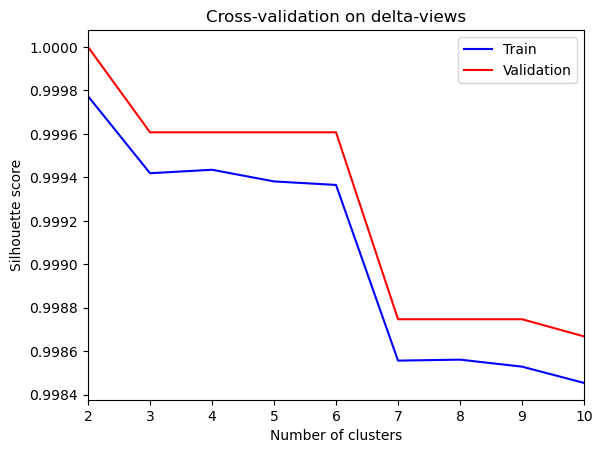

In [14]:
cross_validation(10,"km","delta-views")

We finally do our clustering on the delta-views and visualize the results on the training and testing set. We show the cluster representative (in red) along with all the time series associated with each and the size of the cluster.

In [20]:
def km_show_clusters_with_series(train_labelled,test_labelled,clusterer,title_indicator,WIDTH=2):
    
    fig = plt.figure(constrained_layout=True)
    
    fig.suptitle("Clusters on "+title_indicator)

    subfigs = fig.subfigures(1, 2)
    
    if WIDTH==1:
        subfigs[0].suptitle("Train")
        axs = subfigs[0].subplots(N_CLUSTERS,sharex=True)
        cluster_sizes = {}
        for label in clusterer.labels_:
            cluster_sizes[label] = 0
        for label,serie in tqdm(train_labelled):
            axs[label].plot(date_index,serie,c="gray",alpha=0.01)
            cluster_sizes[label] = cluster_sizes[label] + 1
        i = 0
        for cluster in clusterer.cluster_centers_:
            axs[i].plot(date_index,cluster,c="red")
            axs[i].tick_params(labelrotation=45,labelsize=4)
            axs[i].set_title("Cluster "+str(i+1)+", size "+str(cluster_sizes[i]),fontsize=8)
            axs[i].set_ylabel(title_indicator.capitalize(),fontsize=8)
            axs[i].ticklabel_format(useOffset=False, style='plain', axis='y')
            i += 1

        subfigs[1].suptitle("Test")
        axs = subfigs[1].subplots(N_CLUSTERS,sharex=True)
        cluster_sizes = {}
        for label in clusterer.labels_:
            cluster_sizes[label] = 0
        for label,serie in tqdm(test_labelled):
            axs[label].plot(date_index,serie,c="gray",alpha=0.1)
            cluster_sizes[label] = cluster_sizes[label] + 1
        i = 0
        for cluster in clusterer.cluster_centers_:
            axs[i].plot(date_index,cluster,c="red")
            axs[i].tick_params(labelrotation=45,labelsize=4)
            axs[i].set_title("Cluster "+str(i+1)+", size "+str(cluster_sizes[i]),fontsize=8)
            axs[i].set_ylabel(title_indicator.capitalize(),fontsize=8)
            axs[i].ticklabel_format(useOffset=False, style='plain', axis='y')
            i += 1
            
    else:
        subfigs[0].suptitle("Train")
        axs = subfigs[0].subplots(math.ceil(N_CLUSTERS/WIDTH),WIDTH,sharex=True)
        cluster_sizes = {}
        for label in clusterer.labels_:
            cluster_sizes[label] = 0
        for label,serie in tqdm(train_labelled):
            i = math.floor(label/WIDTH)
            j = label%WIDTH
            axs[(i,j)].plot(date_index,serie,c="gray",alpha=0.01)
            cluster_sizes[label] = cluster_sizes[label] + 1
        i = 0
        j = 0
        for cluster in clusterer.cluster_centers_:
            axs[(i,j)].plot(date_index,cluster,c="red")
            axs[(i,j)].tick_params(labelrotation=45,labelsize=4)
            axs[(i,j)].set_title("Cluster "+str(i*WIDTH+j+1)+", size "+str(cluster_sizes[i*WIDTH+j]),fontsize=8)
            axs[(i,j)].set_ylabel(title_indicator.capitalize(),fontsize=8)
            axs[(i,j)].ticklabel_format(useOffset=False, style='plain', axis='y')
            j += 1
            if j >= WIDTH:
                i += 1
                j = 0
                
        if N_CLUSTERS%2!=0:
            axs.flat[-1].set_visible(False) # to remove last plot


        subfigs[1].suptitle("Test")
        axs = subfigs[1].subplots(math.ceil(N_CLUSTERS/WIDTH),WIDTH,sharex=True)
        cluster_sizes = {}
        for label in clusterer.labels_:
            cluster_sizes[label] = 0
        for label,serie in tqdm(test_labelled):
            i = math.floor(label/WIDTH)
            j = label%WIDTH
            axs[(i,j)].plot(date_index,serie,c="gray",alpha=0.1)
            cluster_sizes[label] = cluster_sizes[label] + 1
        i = 0
        j = 0
        for cluster in clusterer.cluster_centers_:
            axs[(i,j)].plot(date_index,cluster,c="red")
            axs[(i,j)].tick_params(labelrotation=45,labelsize=4)
            axs[(i,j)].set_title("Cluster "+str(i*WIDTH+j+1)+", size "+str(cluster_sizes[i*WIDTH+j]),fontsize=8)
            axs[(i,j)].set_ylabel(title_indicator.capitalize(),fontsize=8)
            axs[(i,j)].ticklabel_format(useOffset=False, style='plain', axis='y')
            j += 1
            if j >= WIDTH:
                i += 1
                j = 0
                
        if N_CLUSTERS%2!=0:
            axs.flat[-1].set_visible(False) # to remove last plot
                
    fig.savefig("plots/clusters_"+title_indicator+".png")

100%|███████████████████████████████████| 14014/14014 [00:10<00:00, 1391.19it/s]


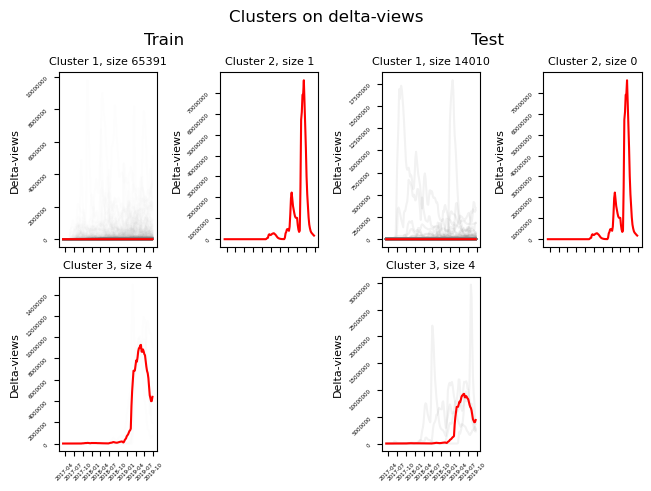

In [23]:
N_CLUSTERS = 3
km = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(train)

train_labelled = list(zip(km.labels_,train))

predicted = km.predict(test)

test_labelled = list(zip(predicted,test))

km_show_clusters_with_series(train_labelled,test_labelled,km,"delta-views")

The results of the clustering on the delta-views are not conclusive. Nearly all the time series belong to one big cluster and it seems that it is not possible to cluster the data into different profiles based on this indicator.

We try the same clustering approach on the delta-subscribers.

In [6]:
subs_timeseries = pd.pivot_table(long_timeseries, values='delta_subs', index=['datetime'], columns=['channel'])
date_index = subs_timeseries.index

subs_timeseries = exp_smoothing(subs_timeseries,2)

series = np.array([subs_timeseries[col].values for col in subs_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)

NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

100%|█████████████████████████████████████████████| 9/9 [07:18<00:00, 48.68s/it]


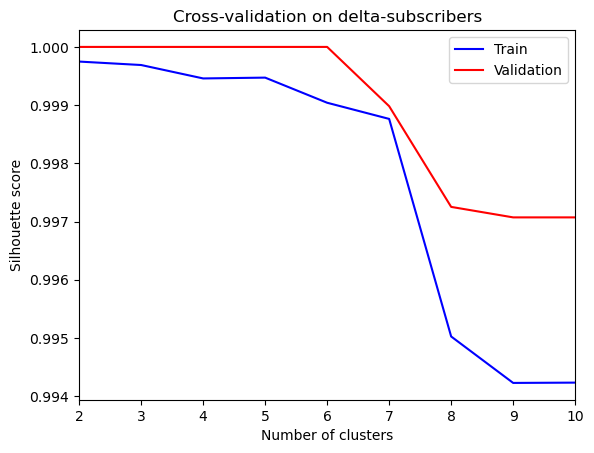

In [11]:
cross_validation(10,"km","delta-subscribers")

100%|███████████████████████████████████| 14014/14014 [00:10<00:00, 1363.43it/s]


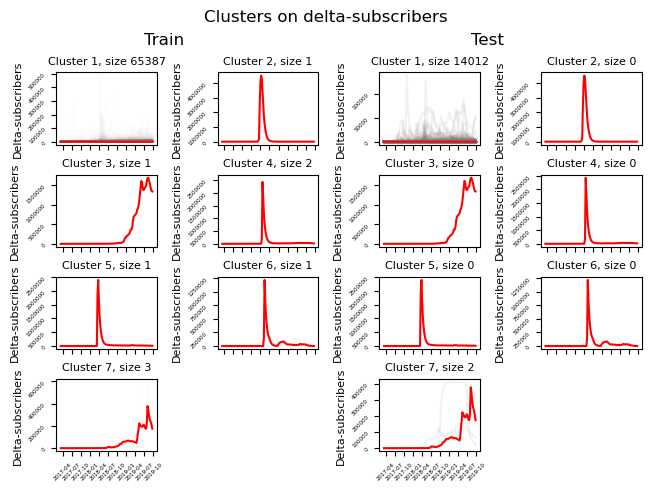

In [16]:
N_CLUSTERS = 7
km = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(train)

train_labelled = list(zip(km.labels_,train))

predicted = km.predict(test)

test_labelled = list(zip(predicted,test))

km_show_clusters_with_series(train_labelled,test_labelled,km,"delta-subscribers")

In the case of the delta-subscribers, we can see immediately from the cross-validation that clustering is gonna be imossible because the silhouette score stays so high even as we add more clusters and it is effectively the case, we get one huge cluster.

We give the clustering approach one last try on the delta-videos this time.

In [24]:
videos_timeseries = pd.pivot_table(long_timeseries, values='delta_videos', index=['datetime'], columns=['channel'])
date_index = videos_timeseries.index

videos_timeseries = exp_smoothing(videos_timeseries,2)

series = np.array([videos_timeseries[col].values for col in videos_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)

NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

100%|█████████████████████████████████████████████| 9/9 [07:23<00:00, 49.28s/it]


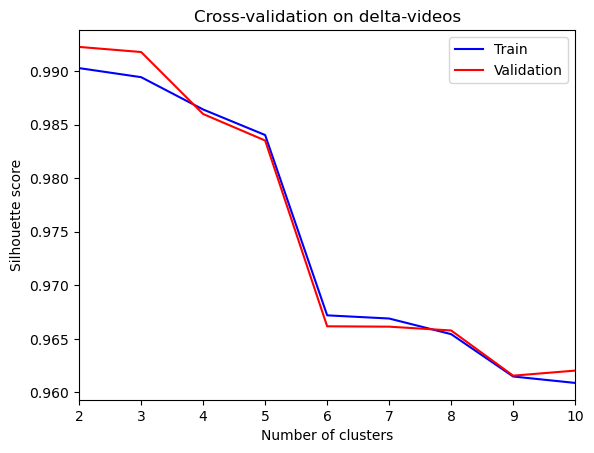

In [25]:
cross_validation(10,"km","delta-videos")

100%|███████████████████████████████████| 14014/14014 [00:12<00:00, 1089.80it/s]


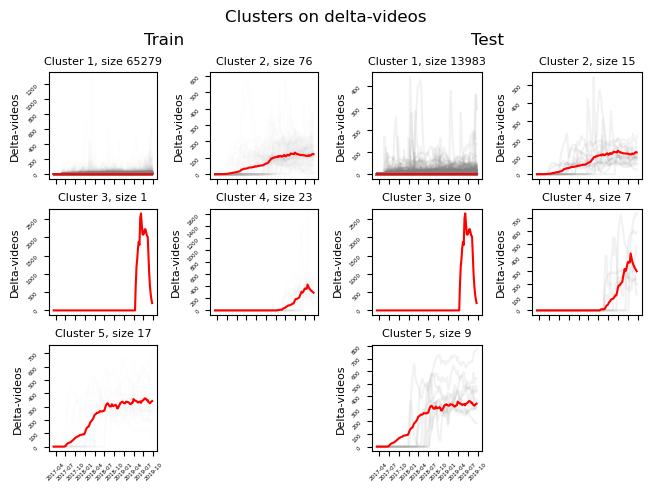

In [26]:
N_CLUSTERS = 5
km = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(train)

train_labelled = list(zip(km.labels_,train))

predicted = km.predict(test)

test_labelled = list(zip(predicted,test))

km_show_clusters_with_series(train_labelled,test_labelled,km,"delta-videos")

The results on the delta-videos are not conclusive either. All the time series are again concentrated on one big cluster.

We tried many others algorithm at the start of our analysis and we even did one more time the entire clustering process using another one called Birch that seemed appropriate for our case. Unfortunately, we didn't get better results. We also tried to do our clustering on the base indicators (views, subscribers and videos, not the delta-ones) but we got similar results and the clusters were less understandable so we decided to stay on the delta-ones.

We also tried to redo our analysis ignoring the "extreme" channels. We filtered out the lowest performing and highest performing quartile on each indicator before clustering to see if there was a difference. It doesn't. The results are the same with an extreme distribution over the available clusters and one of them taking all the spotlight.

In conclusion, it doesn't seem like we can extract general trends on our indicators, or "profiles" of channels. The evolution of the views, subscribers and videos of a channel never seems to follow the same kind of evolution. It is more of a chaotic and unpredictable system where no general trends exist. Maybe we have too much noise when we try analyze the full dataset, we can try to focus on specific parts of it and see if we get different results.

# Focusing on one category

If we cannot find general trends in the evolution on our data for the whole dataset (YouTube in general), maybe we can still find some if we focus our attention on one category in particular. We choose the "Gaming" category as it is well-represented in our dataset.

In [7]:
gaming_timeseries = long_timeseries[long_timeseries['category']=="Howto & Style"]
gaming_timeseries.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
6060,UCxKp57dtigGYrmOUcpaG_0Q,Howto & Style,2017-03-12,101254.750,180.125,11715.250,0.0,174,0,0
6061,UCxKp57dtigGYrmOUcpaG_0Q,Howto & Style,2017-03-19,101446.375,191.625,11708.750,0.0,174,0,0
6062,UCxKp57dtigGYrmOUcpaG_0Q,Howto & Style,2017-03-26,101603.885,157.510,11704.497,0.0,174,0,0
6063,UCxKp57dtigGYrmOUcpaG_0Q,Howto & Style,2017-04-02,101749.240,145.355,11699.057,0.0,174,0,0
6064,UCxKp57dtigGYrmOUcpaG_0Q,Howto & Style,2017-04-09,101914.724,165.484,11690.490,0.0,174,0,0


We try again to cluster the gaming channels into "profiles" using the same approach as earlier.

In [8]:
views_timeseries = pd.pivot_table(gaming_timeseries, values='delta_views', index=['datetime'], columns=['channel'])
date_index = views_timeseries.index

views_timeseries = exp_smoothing(views_timeseries,2)

series = np.array([views_timeseries[col].values for col in views_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)

NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

100%|█████████████████████████████████████████████| 9/9 [00:05<00:00,  1.53it/s]


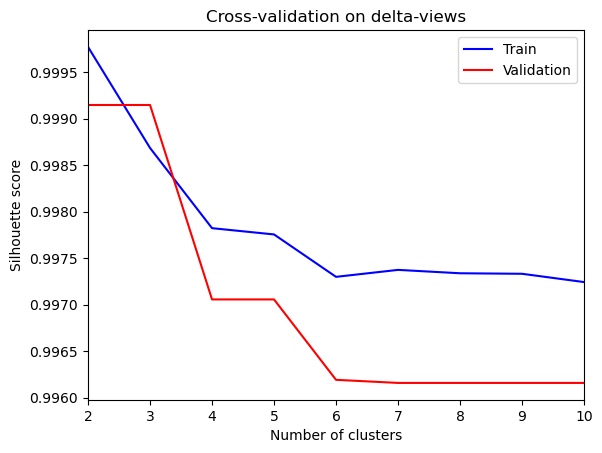

In [9]:
cross_validation(10,"km","delta-views")

100%|█████████████████████████████████████| 1337/1337 [00:00<00:00, 1345.42it/s]


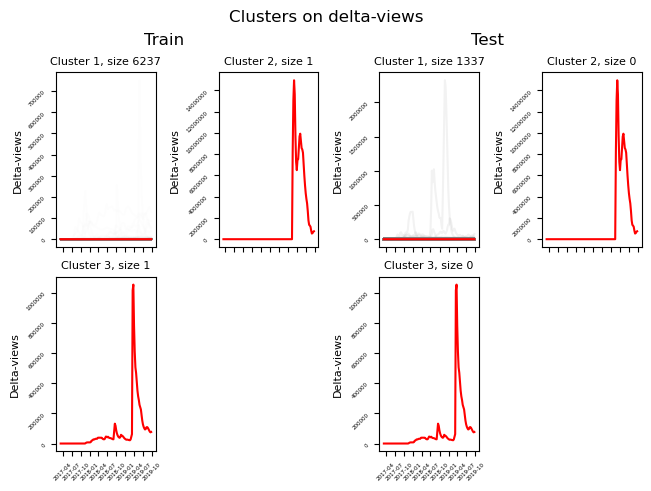

In [11]:
N_CLUSTERS = 3
km = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(train)

train_labelled = list(zip(km.labels_,train))

predicted = km.predict(test)

test_labelled = list(zip(predicted,test))

km_show_clusters_with_series(train_labelled,test_labelled,km,"delta-views")

In [12]:
subs_timeseries = pd.pivot_table(gaming_timeseries, values='delta_subs', index=['datetime'], columns=['channel'])
date_index = subs_timeseries.index

subs_timeseries = exp_smoothing(subs_timeseries,2)

series = np.array([subs_timeseries[col].values for col in subs_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)

NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

100%|█████████████████████████████████████████████| 9/9 [00:05<00:00,  1.51it/s]


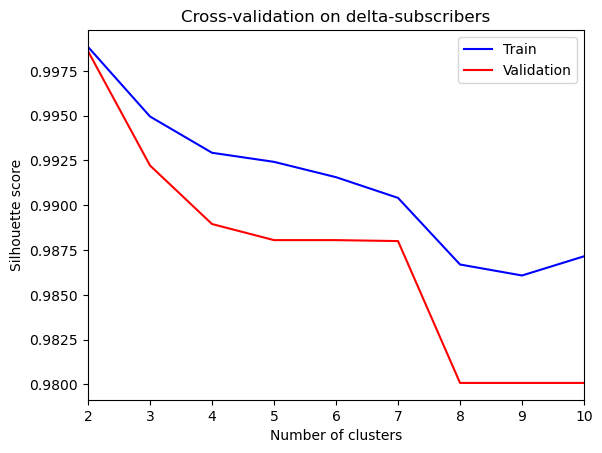

In [13]:
cross_validation(10,"km","delta-subscribers")

100%|█████████████████████████████████████| 1337/1337 [00:01<00:00, 1119.32it/s]


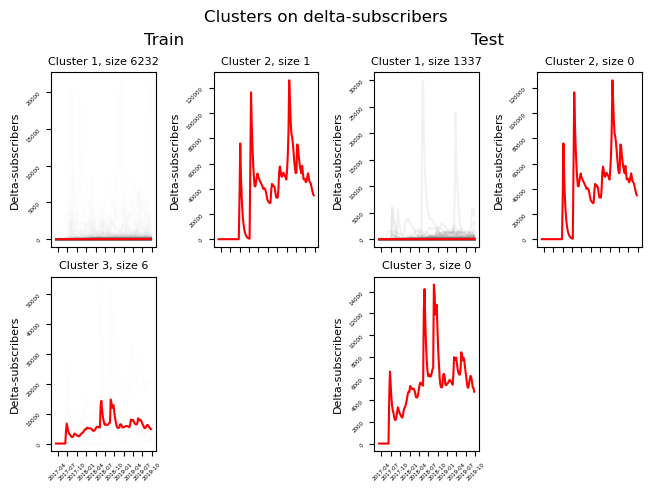

In [15]:
N_CLUSTERS = 3
km = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(train)

train_labelled = list(zip(km.labels_,train))

predicted = km.predict(test)

test_labelled = list(zip(predicted,test))

km_show_clusters_with_series(train_labelled,test_labelled,km,"delta-subscribers")

In [16]:
videos_timeseries = pd.pivot_table(gaming_timeseries, values='delta_videos', index=['datetime'], columns=['channel'])
date_index = subs_timeseries.index

subs_timeseries = exp_smoothing(subs_timeseries,2)

series = np.array([subs_timeseries[col].values for col in subs_timeseries.columns])

train, rest = train_test_split(series,train_size=0.7)
validation, test = train_test_split(rest,test_size=0.5)

NORM_FACTOR = 10
partial_maxabs(NORM_FACTOR)

100%|█████████████████████████████████████████████| 9/9 [00:05<00:00,  1.50it/s]


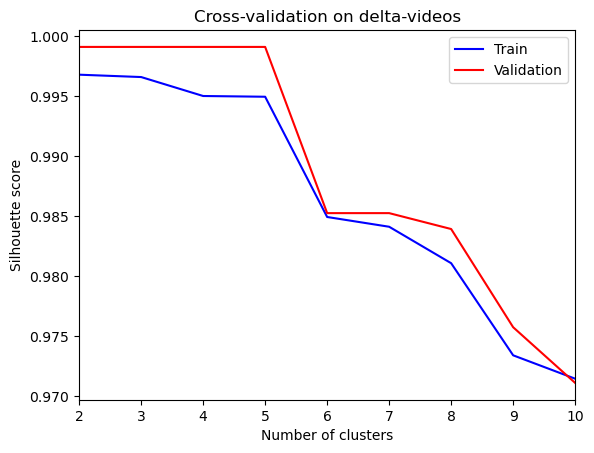

In [17]:
cross_validation(10,"km","delta-videos")

100%|█████████████████████████████████████| 1337/1337 [00:00<00:00, 1394.79it/s]


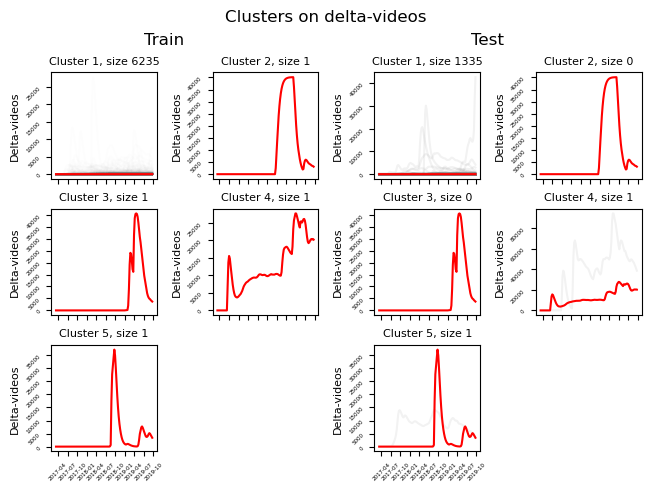

In [18]:
N_CLUSTERS = 5
km = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(train)

train_labelled = list(zip(km.labels_,train))

predicted = km.predict(test)

test_labelled = list(zip(predicted,test))

km_show_clusters_with_series(train_labelled,test_labelled,km,"delta-videos")

Even when focusing only on one specific category, we don't get better clustering results than when we were using the full dataset. It could be different for other categories and we just got no luck but at this point we strongly suspect that the channels are not clusterizable. There are no "profiles" of evolution that we can group the channels into, they all developp differently and, when looked as a whole, quite randomly.

# Forecasting

To validate our last intuition that channels statistics on YouTube are truly unpredictable, we are gonna remove the last part of our time series and try to forecast them. We are gonna do regression on the original time serie using a gradient boosting method called XGBoost to predict how it should evolve and compare it to the true values. It must be said that the library we are using for this is not really made to do this kind of multivariate large-scale time series forecasting but it seems to be quite a common use of it online so we went with it. We will try to forecast the evolution of the three main metrics of a channel, views, subscribers and videos. Here we start with views.

In [3]:
views_timeseries = pd.pivot_table(long_timeseries, values='views', index=['datetime'], columns=['channel'])
date_index = views_timeseries.index

The downside is unfortunately, the training takes way too long on the whole dataset so we have to use a sample of channels only. This method could be extended to run on a server or even a cluster, as the library supports Hadoop and Spark, to work on the whole dataset but considering our last results this was more of a simple test to visually confirm the feeling that we already had. 

In [4]:
views_timeseries = views_timeseries.sample(5000,axis=1)

We use exponential smoothing like we did during the clustering to remove the oscillations and to have cleaner time series to look at.

In [3]:
def exp_smoothing(series,decay):
    return series.ewm(com=decay).mean()

In [6]:
views_timeseries = exp_smoothing(views_timeseries,2)
views_timeseries.head()

channel,UC79H1bXWDNodOD8_VtZd_DA,UCG1acfc735_BPZMEZjuW1Jg,UCKjEtnnXEHsXE9IvCb92V7g,UCUU3lMXc6iDrQw4eZen8COQ,UChbYn187BlBxq5LfGqZSv_A,UCcqZUa6eHw97WV2ysKj9cYA,UCno-YPZ8BiLrN0Wbl8qICFA,UC3xbjTJT2pVNR6b94Vaei5g,UCgy3VdQYAYm33C57aFUfkiQ,UCgeIY1hATJrQ32qJLP52Qtg,...,UCAEo4kIm_Dit6WjwBt4RA2Q,UCMueiUHCb0K-jaRj4zalI7g,UCUglPO1el4LvRS2wAKKMgYg,UCcBSOfh52RnOU27A1cF_k2Q,UCKgv5JA10oXBHjXRBIznw_A,UCRvzsYcJiwbQjsgnFlv-bpA,UCeIUN9eI9jR1ZljYTqK0vSw,UCRwczJ_nk1t9IGHyHfHbXRQ,UC53F8ciG5Oo9foZo-5uye-w,UCdkJ6pj0NXox_M0EpC51iaQ
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-12,1.813269e+07,2.515375e+06,3.062580e+07,1.018628e+08,6.076725e+06,282031.875000,3.355546e+08,1.002821e+08,1.658223e+07,3.903571e+06,...,535752.031000,1.973253e+06,1.065975e+06,76484.375000,9.507988e+06,8.506406e+06,6.041807e+06,2.739200e+07,155220.516000,1.300584e+06
2017-03-19,1.817338e+07,2.559847e+06,3.278824e+07,1.020910e+08,6.141477e+06,283082.250000,3.359591e+08,1.013676e+08,1.668300e+07,3.921726e+06,...,551154.565600,1.984557e+06,1.086538e+06,87857.300000,9.739028e+06,8.688766e+06,6.046645e+06,2.772595e+07,159447.046800,1.314883e+06
2017-03-26,1.823300e+07,2.610507e+06,3.608419e+07,1.023736e+08,6.188187e+06,284071.236316,3.363893e+08,1.026248e+08,1.677678e+07,3.941253e+06,...,582422.700684,1.996619e+06,1.111859e+06,99457.474842,9.995517e+06,8.878269e+06,6.051809e+06,2.815708e+07,165251.235947,1.329834e+06
2017-04-02,1.829695e+07,2.687420e+06,3.951731e+07,1.026395e+08,7.605305e+06,285150.478108,3.368599e+08,1.038488e+08,1.687945e+07,3.961464e+06,...,610316.732708,2.009689e+06,1.137438e+06,111807.510431,1.028378e+07,9.041796e+06,6.057254e+06,2.850164e+07,171592.243708,1.348444e+06
2017-04-09,1.836309e+07,2.800291e+06,4.221193e+07,1.029213e+08,8.692285e+06,286327.109787,3.373514e+08,1.054072e+08,1.699032e+07,3.982910e+06,...,639605.101313,2.024897e+06,1.169153e+06,124542.261166,1.060125e+07,9.276476e+06,6.062994e+06,2.886475e+07,178155.453469,1.368894e+06


As XGBoost cannot work with indexes nor datetime values, we have to rewrite our date index as columns, where we separate the days,month and year.

In [7]:
views_timeseries = views_timeseries.reset_index()
views_timeseries['datetime'] = pd.to_datetime(views_timeseries['datetime'])
views_timeseries['year'] = views_timeseries['datetime'].dt.year
views_timeseries['month'] = views_timeseries['datetime'].dt.month
views_timeseries['day'] = views_timeseries['datetime'].dt.day
views_timeseries = views_timeseries.drop('datetime',axis=1)
views_timeseries.head()

channel,UC79H1bXWDNodOD8_VtZd_DA,UCG1acfc735_BPZMEZjuW1Jg,UCKjEtnnXEHsXE9IvCb92V7g,UCUU3lMXc6iDrQw4eZen8COQ,UChbYn187BlBxq5LfGqZSv_A,UCcqZUa6eHw97WV2ysKj9cYA,UCno-YPZ8BiLrN0Wbl8qICFA,UC3xbjTJT2pVNR6b94Vaei5g,UCgy3VdQYAYm33C57aFUfkiQ,UCgeIY1hATJrQ32qJLP52Qtg,...,UCcBSOfh52RnOU27A1cF_k2Q,UCKgv5JA10oXBHjXRBIznw_A,UCRvzsYcJiwbQjsgnFlv-bpA,UCeIUN9eI9jR1ZljYTqK0vSw,UCRwczJ_nk1t9IGHyHfHbXRQ,UC53F8ciG5Oo9foZo-5uye-w,UCdkJ6pj0NXox_M0EpC51iaQ,year,month,day
0,1.813269e+07,2.515375e+06,3.062580e+07,1.018628e+08,6.076725e+06,282031.875000,3.355546e+08,1.002821e+08,1.658223e+07,3.903571e+06,...,76484.375000,9.507988e+06,8.506406e+06,6.041807e+06,2.739200e+07,155220.516000,1.300584e+06,2017,3,12
1,1.817338e+07,2.559847e+06,3.278824e+07,1.020910e+08,6.141477e+06,283082.250000,3.359591e+08,1.013676e+08,1.668300e+07,3.921726e+06,...,87857.300000,9.739028e+06,8.688766e+06,6.046645e+06,2.772595e+07,159447.046800,1.314883e+06,2017,3,19
2,1.823300e+07,2.610507e+06,3.608419e+07,1.023736e+08,6.188187e+06,284071.236316,3.363893e+08,1.026248e+08,1.677678e+07,3.941253e+06,...,99457.474842,9.995517e+06,8.878269e+06,6.051809e+06,2.815708e+07,165251.235947,1.329834e+06,2017,3,26
3,1.829695e+07,2.687420e+06,3.951731e+07,1.026395e+08,7.605305e+06,285150.478108,3.368599e+08,1.038488e+08,1.687945e+07,3.961464e+06,...,111807.510431,1.028378e+07,9.041796e+06,6.057254e+06,2.850164e+07,171592.243708,1.348444e+06,2017,4,2
4,1.836309e+07,2.800291e+06,4.221193e+07,1.029213e+08,8.692285e+06,286327.109787,3.373514e+08,1.054072e+08,1.699032e+07,3.982910e+06,...,124542.261166,1.060125e+07,9.276476e+06,6.062994e+06,2.886475e+07,178155.453469,1.368894e+06,2017,4,9


We define the last segment of the time series as the 33 last dates. This is the segment that we have to forecast.

In [8]:
steps_to_predict = 33
data_train = views_timeseries[:-steps_to_predict]
data_test  = views_timeseries[-steps_to_predict:]

dates_train = date_index[:-steps_to_predict]
dates_test = date_index[-steps_to_predict:]

To feed it to the XGBoost regressor, we have to split the data separating the date columns that we just made from the real values for the training and testing set.

In [9]:
X_train = data_train[['year','month','day']]
Y_train = data_train.drop(['year','month','day'],axis=1)

X_test = data_test[['year','month','day']]
Y_test = data_test.drop(['year','month','day'],axis=1)

In [10]:
reg = xgb.XGBRegressor()
reg.fit(X_train,Y_train,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [11]:
Y_predict = pd.DataFrame(reg.predict(X_test),columns=Y_test.columns)
Y_predict.head()

channel,UC79H1bXWDNodOD8_VtZd_DA,UCG1acfc735_BPZMEZjuW1Jg,UCKjEtnnXEHsXE9IvCb92V7g,UCUU3lMXc6iDrQw4eZen8COQ,UChbYn187BlBxq5LfGqZSv_A,UCcqZUa6eHw97WV2ysKj9cYA,UCno-YPZ8BiLrN0Wbl8qICFA,UC3xbjTJT2pVNR6b94Vaei5g,UCgy3VdQYAYm33C57aFUfkiQ,UCgeIY1hATJrQ32qJLP52Qtg,...,UCAEo4kIm_Dit6WjwBt4RA2Q,UCMueiUHCb0K-jaRj4zalI7g,UCUglPO1el4LvRS2wAKKMgYg,UCcBSOfh52RnOU27A1cF_k2Q,UCKgv5JA10oXBHjXRBIznw_A,UCRvzsYcJiwbQjsgnFlv-bpA,UCeIUN9eI9jR1ZljYTqK0vSw,UCRwczJ_nk1t9IGHyHfHbXRQ,UC53F8ciG5Oo9foZo-5uye-w,UCdkJ6pj0NXox_M0EpC51iaQ
0,32415322.0,151194480.0,76673576.0,173440608.0,32689368.0,474244.15625,379054752.0,237902912.0,20379916.0,11950848.0,...,7429415.0,4547940.0,9810784.0,24516614.0,35816344.0,25350472.0,6568558.0,147745408.0,1111894.500,8325751.5
1,32663226.0,151157760.0,76452760.0,173444512.0,32632728.0,474307.25000,379075456.0,237737632.0,20375994.0,11949708.0,...,7406531.0,4546675.0,9809993.0,24483456.0,35820756.0,25372856.0,6569232.0,147926944.0,1112074.375,8323792.0
2,32847372.0,149753904.0,76331192.0,173485296.0,32704852.0,474126.90625,378925920.0,237347936.0,20337526.0,11984774.0,...,7365801.0,4549445.0,9789632.0,24534074.0,35775528.0,25378560.0,6562929.0,147774384.0,1108228.750,8326694.5
3,32925410.0,151305904.0,76714928.0,173586384.0,32679688.0,474339.18750,379119808.0,238061056.0,20386710.0,11973660.0,...,7450030.0,4552255.0,9814539.0,24531698.0,35836608.0,25429508.0,6571520.0,147815104.0,1113351.750,8322998.0
4,32716556.0,150856928.0,76233272.0,173444880.0,32700216.0,474212.68750,379112096.0,237925280.0,20380370.0,11958185.0,...,7432465.0,4548987.0,9805958.0,24529510.0,35819400.0,25352040.0,6568526.5,147846944.0,1111860.125,8320051.0


After training the regressor, we try to predict on the test set. Below is a visualization of the values that it forecasted compared to the real evolution of the views.

In [8]:
def plot_forecast(title_indicator):
    HEIGHT = 3
    WIDTH = 3

    fig,axs = plt.subplots(HEIGHT,WIDTH,sharex=True)
    
    fig.suptitle("Forecasting on "+title_indicator)

    selected = Y_train.sample(HEIGHT*WIDTH,axis=1).columns

    for i in range(3):
        for j in range(3):
            axs[(i,j)].tick_params(labelrotation=45,labelsize=5)
            axs[(i,j)].plot(dates_train,Y_train[selected[i*WIDTH+j]],color='blue')
            axs[(i,j)].plot(dates_test,Y_test[selected[i*WIDTH+j]],color='blue')
            axs[(i,j)].plot(dates_test,Y_predict[selected[i*WIDTH+j]],color='red')
            axs[(i,j)].ticklabel_format(useOffset=False, style='plain', axis='y')
            axs[(i,j)].set_ylabel(title_indicator.capitalize(),fontsize=8)
            
    fig.tight_layout()
            
    fig.savefig("plots/forecast_"+title_indicator+".png")

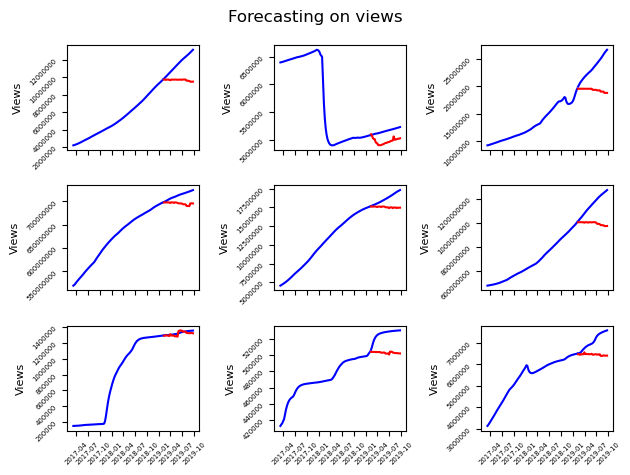

In [27]:
plot_forecast("views")

We repeat the same process for the subscribers and videos statistics.

In [5]:
subs_timeseries = pd.pivot_table(long_timeseries, values='subs', index=['datetime'], columns=['channel'])
date_index = subs_timeseries.index

subs_timeseries = subs_timeseries.sample(5000,axis=1)

subs_timeseries = exp_smoothing(subs_timeseries,2)

subs_timeseries = subs_timeseries.reset_index()
subs_timeseries['datetime'] = pd.to_datetime(subs_timeseries['datetime'])
subs_timeseries['year'] = subs_timeseries['datetime'].dt.year
subs_timeseries['month'] = subs_timeseries['datetime'].dt.month
subs_timeseries['day'] = subs_timeseries['datetime'].dt.day
subs_timeseries = subs_timeseries.drop('datetime',axis=1)

steps_to_predict = 33
data_train = subs_timeseries[:-steps_to_predict]
data_test  = subs_timeseries[-steps_to_predict:]

dates_train = date_index[:-steps_to_predict]
dates_test = date_index[-steps_to_predict:]

X_train = data_train[['year','month','day']]
Y_train = data_train.drop(['year','month','day'],axis=1)

X_test = data_test[['year','month','day']]
Y_test = data_test.drop(['year','month','day'],axis=1)

In [6]:
reg = xgb.XGBRegressor()
reg.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)],verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [7]:
Y_predict = pd.DataFrame(reg.predict(X_test),columns=Y_test.columns)
Y_predict.head()

channel,UCvCWdLK5BKIA0OPhv9LyGug,UCEKjWYp5HDxNxSHWx8LjBpA,UCxLv22Ws15qC7ztI3Ag49kw,UCAaa0mleeU128Ad5iM1RFIg,UCjlYjLtJhkPjQp7SxYfyVRA,UCB7ViK_fZPd3-3XzIgQKWYg,UCRysEEJV5veNYdfGgRPyrHQ,UCt_yQ2pbZ4Rk5vU7yLmiNcw,UCLFlcGY4MWgBEixrF55HKew,UC5CLbqqdnKUzYNyS_kMbnIg,...,UCJWatPz9_hy6qb3xFF6d8hg,UCspGQ8deS7Svyk998-0D0JQ,UC0-p7mK8hRVvV86yREq342A,UCHLyP4MuA-JAFBCwxXOEDdA,UCgAYWS3ldZMhsBpXi6kn2Yw,UC3iZzCe7M5nLMPjm5Yh91hw,UC5MkxrHWkLDDnToq_ZTYGlA,UC9AaYXbH5qvbYSccHhiCWZQ,UCzAebatotIE2I76ShQvbl_A,UCqDmz99BDktAyLPzf9xopeA
0,17434.187500,42824.582031,132998.078125,226441.468750,135991.890625,10397.244141,39363.507812,19642.976562,10812.946289,161044.984375,...,85631.390625,10014.254883,184041.796875,39489.406250,13290.023438,23034.861328,137834.390625,10418.770508,456246.34375,110227.562500
1,17427.722656,42800.414062,133057.031250,226284.968750,136052.218750,10400.462891,39372.660156,19641.271484,10823.626953,161012.671875,...,85635.531250,10018.662109,184247.328125,39485.449219,13286.238281,23034.662109,137890.578125,10390.601562,456064.00000,110359.648438
2,17396.716797,42737.652344,133071.171875,226346.546875,135785.203125,10319.101562,39350.718750,19645.595703,10825.609375,161008.812500,...,85433.398438,10026.782227,184292.031250,39371.406250,13312.016602,23113.427734,138013.031250,10435.078125,456216.18750,110318.593750
3,17438.117188,42812.972656,133037.125000,226545.296875,135925.187500,10406.710938,39367.062500,19662.046875,10961.314453,160999.937500,...,85626.421875,10024.040039,185309.125000,39508.726562,13336.705078,23034.447266,138069.750000,10669.933594,456341.65625,110477.890625
4,17431.644531,42802.800781,132918.906250,226435.203125,135954.515625,10399.339844,39367.558594,19650.210938,10961.326172,161088.000000,...,85601.398438,10016.794922,184032.734375,39497.988281,13303.843750,23031.099609,137833.390625,10721.984375,456318.90625,110205.859375


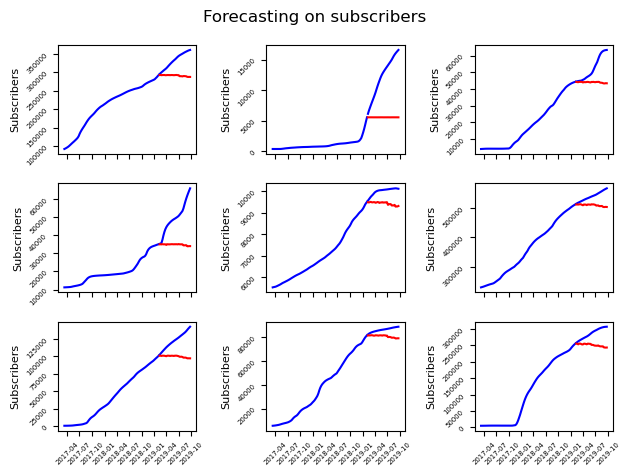

In [8]:
plot_forecast("subscribers")

In [4]:
videos_timeseries = pd.pivot_table(long_timeseries, values='videos', index=['datetime'], columns=['channel'])
date_index = videos_timeseries.index

videos_timeseries = videos_timeseries.sample(5000,axis=1)

videos_timeseries = exp_smoothing(videos_timeseries,2)

videos_timeseries = videos_timeseries.reset_index()
videos_timeseries['datetime'] = pd.to_datetime(videos_timeseries['datetime'])
videos_timeseries['year'] = videos_timeseries['datetime'].dt.year
videos_timeseries['month'] = videos_timeseries['datetime'].dt.month
videos_timeseries['day'] = videos_timeseries['datetime'].dt.day
videos_timeseries = videos_timeseries.drop('datetime',axis=1)

steps_to_predict = 33
data_train = videos_timeseries[:-steps_to_predict]
data_test  = videos_timeseries[-steps_to_predict:]

dates_train = date_index[:-steps_to_predict]
dates_test = date_index[-steps_to_predict:]

X_train = data_train[['year','month','day']]
Y_train = data_train.drop(['year','month','day'],axis=1)

X_test = data_test[['year','month','day']]
Y_test = data_test.drop(['year','month','day'],axis=1)

In [5]:
reg = xgb.XGBRegressor()
reg.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)],verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [6]:
Y_predict = pd.DataFrame(reg.predict(X_test),columns=Y_test.columns)
Y_predict.head()

channel,UCVS70GMQFMERyUG2mp7pyrw,UCboO-orWDjoSrZ2yqJRQpBQ,UCCBlFQZzELVGi7BIYgieIYg,UCfsFe3_oQMzmrEecXVBdXIA,UCRuzc0H9RlMHPkZy9n920Qg,UC8LAjwYNKOEd2Ar5YaooA4A,UCE9JRvrVApGqlptEB4UkPjg,UCvGWlVJ7jii1a6gZY9acAoA,UCZNWID6BlOpYrDMj8UpGEPA,UCzzfu83LhPMMuhtDVA75rfw,...,UC1o66cdPSjPlcI2Bq2zoeEA,UCPntg-Vp9Kvr2p59MurlQPw,UC4GJndVHEhdmqLFBHOCi97A,UCWMAuteVQ9yvSSol784rVjg,UCh2ZjNuq5FfAQEP44QiaWRA,UCjxExztw3c_PeIt5BYW17TA,UCs9wGXdQrN9-dcQucuzRzNw,UCfM1o8q1hiCgkBpjmLCmJ9g,UC6rrBCCDvrDFcOJHifruL5A,UCtz4a0oDiRqmFreYwvR-xTQ
0,125.528496,145.050034,225.752167,384.654663,46.960812,219.002655,238.220840,466.794891,318.169525,262.255341,...,438.539276,137.875397,109.272636,22.988810,148.539688,280.535828,63.456676,179.391708,155.020737,283.594299
1,125.536613,144.999557,225.791519,384.841888,46.996834,219.067062,238.354187,466.486237,318.041138,262.288177,...,438.506531,137.775894,109.319427,22.979773,148.437256,280.543610,63.447361,179.578674,154.957153,283.624084
2,125.421082,145.033432,225.708084,384.618103,46.984261,219.090439,237.196198,467.006500,318.065033,262.133789,...,438.286743,137.924347,109.306702,22.954315,148.294876,280.204010,63.400101,179.775131,155.191132,283.315643
3,125.553078,144.961380,224.087372,384.910187,46.983669,219.226807,238.351517,466.820496,318.177795,262.275421,...,438.573730,137.930161,109.211189,22.998621,148.475189,280.550018,63.655857,179.670105,155.248260,283.660828
4,125.531158,145.043060,225.935684,384.643005,46.942535,219.377441,238.235550,466.853943,318.165314,262.290588,...,438.508698,138.145706,109.117928,22.985920,148.539734,280.549896,63.458027,179.774353,155.013336,283.596527


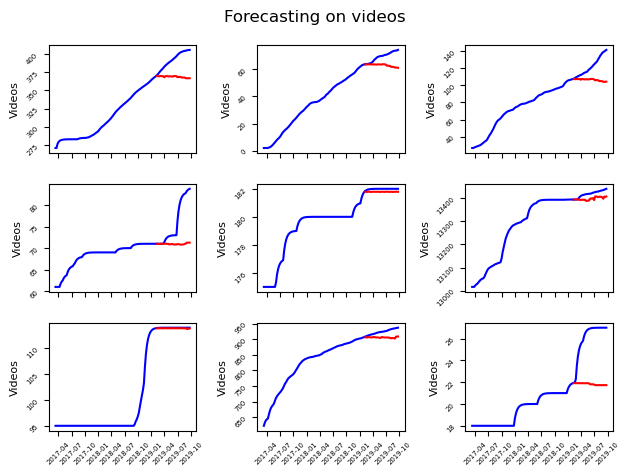

In [9]:
plot_forecast("videos")

As suspected, the forecasting is inconclusive on all three of the statistics, views, subscribers and videos. The best prediction is often just the last value given. This is one more indication that comforts us in our supposition that the channel evolution on YouTube is unpredictable.